## Particle-particle interaction example

In this notebook, we show an example of the new 'particle-particle-interaction' functionality in Parcels. Note that this functionality is still in development, and the implementation is fairly rudimentary and slow for now. Importantly:
- Particle-particle interaction only works in Scipy mode
- The type of interactions that are supported is still limited

Interactions are implemented through `InteractionKernels`, which are similar to normal `Kernels`. The `InteractionKernels` are applied between particles that are located closer to each other than a specified `interaction_distance`. In general, the code structure needs three adaptations to apply particle-particle interaction:
1. The `ParticleSet` requires an `interaction_distance` argument upon creation, to define the `interaction_distance`.
2. `ParticleSet.execute()` requires the `pyfunc_inter` argument, which contains the `InteractionKernels` that will be executed, similarly to the `pyfunc` argument for normal `Kernels`.
3. `InteractionKernels` have two additional arguments compared to normal `Kernels`: 
```python
def InteractionKernel(particle, fieldset, time, neighbors, mutator)
```

The `neighbors` argument provides a list of the particles that are within a neighborhood (i.e. closer than the `interaction_distance` argument in `ParticleSet` creation). 

The `mutator` argument is an initially empty list with all the mutations that need to be performed on particles at the end of running all `InteractionKernels` on all particles. 
This `mutator` argument is required, because otherwise the order at which interactions are applied has implications for the simulation. As a consequence, the simulation will likely be dependent on the order of the particle list if no mutator list is used. See the [**Mutator function**](#mutator_function) section for an illustration of the `mutator` functionality.

### Pulling particles

Below is an example of what can be done with particle-particle interaction. We create a square grid of $N\times N$ particles, which are all subject to Brownian Motion (via the built-in `DiffusionUniformKh` Kernel). Furthermore, some of the particles also 'attract' other particles that are within the interaction distance: these attracted particles move with a constant velocity to the attracting particles.

In [5]:
%matplotlib notebook
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from parcels import FieldSet
from parcels import ParticleSet
from parcels import Variable
from parcels import ScipyParticle, ScipyInteractionParticle
from parcels import DiffusionUniformKh
from parcels import NearestNeighborWithinRange, MergeWithNearestNeighbor

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [6]:
def Pull(particle, fieldset, time, neighbors, mutator):
    '''InterActionKernel that "pulls" all neighbor particles 
    toward the attracting particle with a constant velocity '''
    distances = []
    na_neighbors = []
    if not particle.attractor:  # only execute kernel for particles that are 'attractor'
        return StateCode.Success
    for n in neighbors:
        if n.attractor:
            continue
        x_p = np.array([particle.depth, particle.lat, particle.lon])
        x_n = np.array([n.depth, n.lat, n.lon])
        distances.append(np.linalg.norm(x_p-x_n))  # compute distance between attracted and attracting particle
        na_neighbors.append(n)

    velocity = 0.04  # predefined attracting velocity
    for n in na_neighbors:
        assert n.dt == particle.dt
        dx = np.array([particle.lat-n.lat, particle.lon-n.lon,
                       particle.depth-n.depth])
        dx_norm = np.linalg.norm(dx)

        distance = velocity*n.dt
        d_vec = distance*dx/dx_norm  # calculate vector of position change

        def f(n, dlat, dlon, ddepth):  # define mutation function for mutator
            n.lat += dlat
            n.lon += dlon
            n.depth += ddepth

        mutator[n.id].append((f, d_vec))  # add mutation to the mutator


In [7]:
npart = 11

X, Y = np.meshgrid(np.linspace(-1, 1, npart), np.linspace(-1, 1, npart))

# Define a fieldset without flow
fieldset = FieldSet.from_data({'U': 0, 'V': 0}, {'lon': 0, 'lat': 0}, mesh='flat')
fieldset.add_constant_field("Kh_zonal", 0.0005, mesh="flat")
fieldset.add_constant_field("Kh_meridional", 0.0005, mesh="flat")

# Create custom particle class with extra variable that indicates
# whether the interaction kernel should be executed on this particle.
class InteractingParticle(ScipyParticle):
    attractor = Variable('attractor', dtype=np.bool_, to_write='once')

attractor = [True if i in [int(npart*npart/2-3), int(npart*npart/2+3)] else False for i in range(npart*npart)]
pset = ParticleSet(fieldset=fieldset, pclass=InteractingParticle,
                   lon=X, lat=Y,
                   interaction_distance=0.5,  # note the interaction_distance argument here
                   attractor=attractor)

output_file = pset.ParticleFile(name="InteractingParticles.nc", outputdt=1)

pset.execute(pyfunc=DiffusionUniformKh, 
             pyfunc_inter=Pull,  # note the pyfunc_inter here
             runtime=60, dt=1, output_file=output_file)

output_file.close()

sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command not found
sh: None: command no

KernelError: 0
Particle P[4](lon=-1.000000, lat=-1.000000, depth=0.000000, attractor=0.000000, time=0.000000)
Time: 0.0,	timestep dt: 1.000000
Error: Error during compilation:
Compilation command: x86_64-apple-darwin13.4.0-clang -Wall -fPIC -std=gnu11 -I/Users/nooteboom/Documents/GitHub/parcelsversions/parcels_uptodate/parcels/parcels/include -g -O3 -m64 -o /var/folders/n8/0pdy5rq51vx91107pw15_d3w0000gq/T/parcels-503/libparcels_random_00f44240-c52e-45e5-8b5e-6609f8d5b849.so /var/folders/n8/0pdy5rq51vx91107pw15_d3w0000gq/T/parcels-503/parcels_random_00f44240-c52e-45e5-8b5e-6609f8d5b849.c -shared -lm -m64
Source/Destination file: /var/folders/n8/0pdy5rq51vx91107pw15_d3w0000gq/T/parcels-503/parcels_random_00f44240-c52e-45e5-8b5e-6609f8d5b849.c
Log file: /var/folders/n8/0pdy5rq51vx91107pw15_d3w0000gq/T/parcels-503/parcels_random_00f44240-c52e-45e5-8b5e-6609f8d5b849.log

Log output: dyld: Symbol not found: __ZN4llvm10CallbackVH6anchorEv
  Referenced from: /Users/nooteboom/opt/anaconda3/envs/py3_parcels_tutorials/bin/../lib/libclang-cpp.12.dylib
  Expected in: /Users/nooteboom/opt/anaconda3/envs/py3_parcels_tutorials/bin/../lib/libLLVM-12.dylib
 in /Users/nooteboom/opt/anaconda3/envs/py3_parcels_tutorials/bin/../lib/libclang-cpp.12.dylib


In [ ]:
%%capture
data_xarray = xr.open_dataset('InteractingParticles.nc')
data_attr = data_xarray.where(data_xarray['attractor']==1, drop=True)
data_other = data_xarray.where(data_xarray['attractor']==0, drop=True)

timerange = np.arange(np.nanmin(data_xarray['time'].values),
                      np.nanmax(data_xarray['time'].values), np.timedelta64(1, 's'))  # timerange in nanoseconds

fig = plt.figure(figsize=(4, 4),constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel('Meridional distance [m]')
ax.set_xlabel('Zonal distance [m]')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

time_id = np.where(data_other['time'] == timerange[0]) # Indices of the data where time = 0
time_id_attr = np.where(data_attr['time'] == timerange[0]) # Indices of the data where time = 0

scatter = ax.scatter(data_other['lon'].values[time_id], data_other['lat'].values[time_id], c='b', s=5,zorder=1)
scatter_attr = ax.scatter(data_attr['lon'].values[time_id_attr], data_attr['lat'].values[time_id_attr], c='r', s=40,zorder=2)

circs = []
for lon_a, lat_a in zip(data_attr['lon'].values[time_id_attr], data_attr['lat'].values[time_id_attr]):
    circs.append(ax.add_patch(plt.Circle((lon_a, lat_a), 0.25, facecolor='None', edgecolor='r', linestyle='--')))

t = str(timerange[0].astype('timedelta64[s]'))
title = ax.set_title('Particles at t = '+t+' (Red particles are attractors)')

def animate(i):
    t = str(timerange[i].astype('timedelta64[s]'))
    title.set_text('Particles at t = '+t+'\n (Red particles are attractors)')
    
    time_id = np.where(data_other['time'] == timerange[i])
    time_id_attr = np.where(data_attr['time'] == timerange[i])
    scatter.set_offsets(np.c_[data_other['lon'].values[time_id], data_other['lat'].values[time_id]])
    scatter_attr.set_offsets(np.c_[data_attr['lon'].values[time_id_attr], data_attr['lat'].values[time_id_attr]])
    for c, lon_a, lat_a in zip(circs, data_attr['lon'].values[time_id_attr], data_attr['lat'].values[time_id_attr]):
        c.center = (lon_a, lat_a)
    return scatter, scatter_attr, circs,
    
anim = FuncAnimation(fig, animate, frames = len(timerange), interval=500, blit=True)
data_xarray.close()

In [ ]:
HTML(anim.to_jshtml())

### Merging particles

Another type of interaction that is supported is the merging of particles. The supported merging functions also comes with limitations (only mutual-nearest particles can be accurately merged), so this is really just a prototype. Nevertheless, the example below shows the possibilities that merging of particles can provide for more complex simulations.

In the example below, we use two build-in Kernels: `NearestNeighborWithinRange` and `MergeWithNearestNeighbor`. 

In [ ]:
npart = 800

X = np.random.uniform(-1, 1, size=npart)
Y = np.random.uniform(-1, 1, size=npart)

# Define a fieldset without flow
fieldset = FieldSet.from_data({'U': 0, 'V': 0}, {'lon': 0, 'lat': 0}, mesh='flat')
fieldset.add_constant_field("Kh_zonal", 0.0005, mesh="flat")
fieldset.add_constant_field("Kh_meridional", 0.0005, mesh="flat")

# Create custom InteractionParticle class with extra variables neirest_neighbor and mass
class MergeParticle(ScipyInteractionParticle):
    nearest_neighbor = Variable('nearest_neighbor', dtype=np.int64, to_write=False)
    mass = Variable('mass', initial=1, dtype=np.float32)

pset = ParticleSet(fieldset=fieldset, pclass=MergeParticle,
                   lon=X, lat=Y,
                   interaction_distance=0.05)  # note the interaction_distance argument here

output_file = pset.ParticleFile(name="MergingParticles.nc", outputdt=1)

pset.execute(pyfunc=DiffusionUniformKh, 
             pyfunc_inter=pset.InteractionKernel(NearestNeighborWithinRange) + MergeWithNearestNeighbor,  # note the pyfunc_inter here
             runtime=60, dt=1, output_file=output_file)

output_file.close()

In [ ]:
%%capture
data_xarray = xr.open_dataset('MergingParticles.nc')

timerange = np.arange(np.nanmin(data_xarray['time'].values),
                      np.nanmax(data_xarray['time'].values), np.timedelta64(1, 's'))  # timerange in nanoseconds

fig = plt.figure(figsize=(4, 4),constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel('Meridional distance [m]')
ax.set_xlabel('Zonal distance [m]')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

time_id = np.where(data_xarray['time'] == timerange[0]) # Indices of the data where time = 0

scatter = ax.scatter(data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id], 
                     s=data_xarray['mass'].values[time_id], c='b', zorder=1)

t = str(timerange[0].astype('timedelta64[s]'))
title = ax.set_title('Particles at t = '+t)

def animate(i):
    t = str(timerange[i].astype('timedelta64[s]'))
    title.set_text('Particles at t = '+t)
    
    time_id = np.where(data_xarray['time'] == timerange[i])
    scatter.set_offsets(np.c_[data_xarray['lon'].values[time_id], data_xarray['lat'].values[time_id]])
    scatter.set_sizes(data_xarray['mass'].values[time_id])

    return scatter,
    
anim = FuncAnimation(fig, animate, frames = len(timerange), interval=500, blit=True)
data_xarray.close()

In [ ]:
HTML(anim.to_jshtml())

### Interacting with the FieldSet
An important feature of Parcels is to evaluate a `Field` at the `Particle` location using the square bracket notation: `particle.Temperature = fieldset.T[time, depth, lat, lon]`. These types of particle-field interactions are recommended to be implemented in standard `Kernels`, since the `InteractionKernels` do not report the `StateCodes` that are used to flag particles that encounter an error in the particle-field interaction, e.g. `OutOfBoundsError`. Any variable that is needed in the particle-particle interaction can be stored in a `Variable` by sampling the field in a `Kernel` before executing the `InteractionKernel`. 

## Mutator function<a id='mutator_function'></a>

To illustrate the role of the mutator list, we define two particles, where particle 1 moves towards particle 2, while particle 2 moves away from particle 1. Both particles move with the same velocity, which depends on the distance between both particles. Since both particles move with the same velocity, one would expect that the distance between both particles remains the same.

In [1]:
# First, set up the simulation
%matplotlib notebook
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from parcels import FieldSet, ParticleSet, Variable, ScipyParticle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

npart = 11

# The distance between both particles is 0.5 at the start
X = [0.3, 0.8]
Y = [0.5, 0.5]

# Define a fieldset without flow
fieldset = FieldSet.from_data({'U': 0, 'V': 0}, {'lon': 0, 'lat': 0}, mesh='flat')

# Create custom particle class with extra variable that indicates
# whether the particle swims towards or away from the other particle
class InteractingParticle(ScipyParticle):
    ptype = Variable('ptype', dtype=np.int_, to_write='once')

# Particle 1 swims towards particle 2
# Particle 2 swims away from particle 1
ptype = [1, -1]

In [2]:
# The Kernel that moves the particles
def Move(particle, fieldset, time, neighbors, mutator):
    '''InterActionKernel that moves particle towards
    neihbouring particles'''
    velocity = 0.15 * particle.ptype  # predefined velocity scale
    for n in neighbors:
        dx = np.array([particle.lat-n.lat, particle.lon-n.lon,
                       particle.depth-n.depth])
        distance = velocity*n.dt
        d_vec = distance*dx  # calculate vector of position change

        if(fieldset.UseMutator): # If the mutator is used
            def f(n, dlat, dlon, ddepth):  # define mutation function for mutator
                n.lat += dlat
                n.lon += dlon
                n.depth += ddepth
            mutator[n.id].append((f, d_vec))  # add mutation to the mutator
        else: # If the mutator is not used
            n.lat += d_vec[0]
            n.lon += d_vec[1]
            n.depth += d_vec[2]

# The function that creates the animation
def Animate():
    data_xarray = xr.open_dataset('InteractingParticles.nc')
    data_attr = data_xarray.where(data_xarray['ptype']==1, drop=True)
    data_other = data_xarray.where(data_xarray['ptype']==-1, drop=True)

    timerange = np.arange(np.nanmin(data_xarray['time'].values),
                          np.nanmax(data_xarray['time'].values), np.timedelta64(1, 's'))  # timerange in nanoseconds

    fig = plt.figure(figsize=(4, 4), constrained_layout=True)
    ax = fig.add_subplot()

    ax.set_ylabel('Meridional distance [m]')
    ax.set_xlabel('Zonal distance [m]')
    ax.set_xlim(-2.0, 1.1)
    ax.set_ylim(-1.1, 1.1)

    time_id = np.where(data_other['time'] == timerange[0]) # Indices of the data where time = 0
    time_id_attr = np.where(data_attr['time'] == timerange[0]) # Indices of the data where time = 0

    scatter = ax.scatter(data_other['lon'].values[time_id],
                         data_other['lat'].values[time_id],
                         c='b', s=5, zorder=1, label='Particle 1')
    scatter_attr = ax.scatter(data_attr['lon'].values[time_id_attr],
                              data_attr['lat'].values[time_id_attr],
                              c='r', s=40,zorder=2, label='Particle 2')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.5))
    t = str(timerange[0].astype('timedelta64[s]'))
    title = ax.set_title('Particles at t = '+t)

    def animate(i):
        t = str(timerange[i].astype('timedelta64[s]'))
        title.set_text('Particles at t = '+t)

        time_id = np.where(data_other['time'] == timerange[i])
        time_id_attr = np.where(data_attr['time'] == timerange[i])
        scatter.set_offsets(np.c_[data_other['lon'].values[time_id], data_other['lat'].values[time_id]])
        scatter_attr.set_offsets(np.c_[data_attr['lon'].values[time_id_attr], data_attr['lat'].values[time_id_attr]])

        return scatter, scatter_attr

    anim = FuncAnimation(fig, animate, frames = len(timerange), interval=500, blit=True)
    data_xarray.close()
    plt.close()
    return anim

<IPython.core.display.Javascript object>


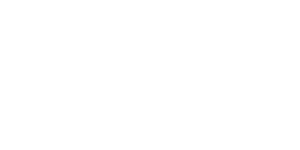

In [3]:
# Start the simulation without the mutator function
fieldset.add_constant('UseMutator', False)

pset = ParticleSet(fieldset=fieldset, pclass=InteractingParticle,
                   lon=X, lat=Y,
                   interaction_distance=0.7,  # note the interaction_distance argument here
                   ptype=ptype)
output_file = pset.ParticleFile(name="InteractingParticles.nc", outputdt=1)
pset.execute(#pyfunc=DiffusionUniformKh, 
             pyfunc_inter=Move,  # note the pyfunc_inter here
             runtime=60, dt=1, output_file=output_file)
output_file.close()
anim = Animate()  # Create animation
HTML(anim.to_jshtml())

Without mutator function, the location of particle 1 is updated before the location of particle 2 every time step. As a result, the particle 1 moves slightly faster than particle 2 and their distance reduces.

<IPython.core.display.Javascript object>


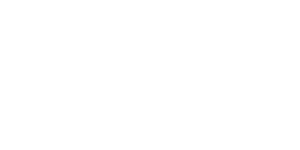

In [4]:
# Start the same simulation, but with the mutator function
fieldset.add_constant('UseMutator', True)

pset = ParticleSet(fieldset=fieldset, pclass=InteractingParticle,
                   lon=X, lat=Y,
                   interaction_distance=0.7,  # note the interaction_distance argument here
                   ptype=ptype)
output_file = pset.ParticleFile(name="InteractingParticles.nc", outputdt=1)

pset.execute(#pyfunc=DiffusionUniformKh, 
             pyfunc_inter=Move,  # note the pyfunc_inter here
             runtime=60, dt=1, output_file=output_file)
output_file.close()
anim = Animate()
HTML(anim.to_jshtml())

When the mutator function is used, both particle locations are updated at the end of every timestep. Hence, both particles move with the same velocity and their distance remains the same throughout the simulation.